In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize
import json
import matplotlib

In [2]:
def gcd(m, n): # euclid's algorithm
    a = max(m,n)
    b = min(m,n)
    if a%b == 0:
        return a, b
    c = a % b
    return gcd(b, c) # c a legnagyobb közös osztó

# determines if n is probably-prime or composite using miller rabin test. Tests k times
def is_prime(n, k=20): # miller-rabin test
    if n == 2:
        return True
    for _ in range(k):
        witness = 1
        a = random.randint(2, n-1)
        if gcd(a, n)[1] != 1:
            return False
        d = n-1
        r = 0
        while d % 2 == 0:
            d = d//2
            r += 1
        s = int_pow_mod(a, d, n)
        if s == 1:
            witness = 0
        for i in range(r):
            if s == n-1:
                witness = 0
            s = s**2 % n
        if witness == 1:
            return False
    return True

In [3]:
def int_nth_root(A, n): # calculate floor of nth root of A
    if A<0:
        if n%2 == 0:
            raise ValueError
        return -int_nth_root(-A,n)
    if A==0:
        return 0
    n1 = n-1
    if A.bit_length() < 1024: # float(n) safe from overflow
        xk = int( round( pow(A,1.0/n) ) )
        xk = ( n1*xk + A//pow(xk,n1) )//n # Ensure xk >= floor(nthroot(A)).
    else:
        xk = 1 << -(-A.bit_length()//n) # 1 << sum(divmod(A.bit_length(),n))
                                        # power of 2 closer but greater than the nth root of A
    while True:
        d = A // pow(xk,n1)
        if xk <= d:
            return xk
        xk = (n1*xk + d)//n

In [4]:
def two_pow(A, k): # computes A**(2**k), A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 
    return result  # if k < L: max O(L^3) operations

def int_pow(A, n): # computes A**n in polynomal time, A: L bit int
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow(A, i)
    return result # if n < A: max O(L^4) operations

In [5]:
def two_pow_mod(A, k, N): #computes A**(2**k) mod N, A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 % N
    return result  # if  k < L: max O(L^3)

def int_pow_mod(A, n, N): #computes A**n mod N in polynomal time, A: L bit integer
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow_mod(A, i, N) % N
    return result # if n < A:max O(L^4) operations

In [6]:
def find_int_pow(N):
    n = N.bit_length()
    for i in range(2, n):
        a = int_nth_root(N, i)
        if int_pow(a, i) == N:
            return a, i
    return N, 1

def order(a, N): 
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    s = 1
    i = 0
    while i == 0 or s != 1:
        s = (a*s) % N
        i += 1
    return i

# Futtatások száma hibákkal

In [7]:
def expect(n, p=0): # estimate of expected value of number of runs
    P = (1-p)**(2*n+2)
    return 2*np.log(np.log(2)*n)*np.exp(np.euler_gamma)/P

def dep(n):
    return 232*n**3+282*n**2+32*n

def cx(n):
    return 16*n**4+152*n**3+188*n**2+104*n

def sing(n):
    return 24*n**4 + 176*n**3 + 230*n**2 + 139*n

## Readout error

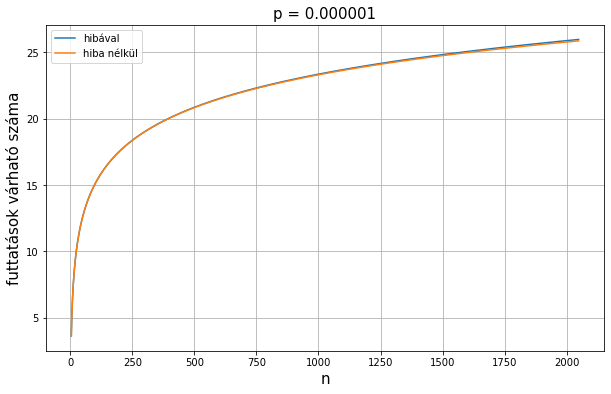

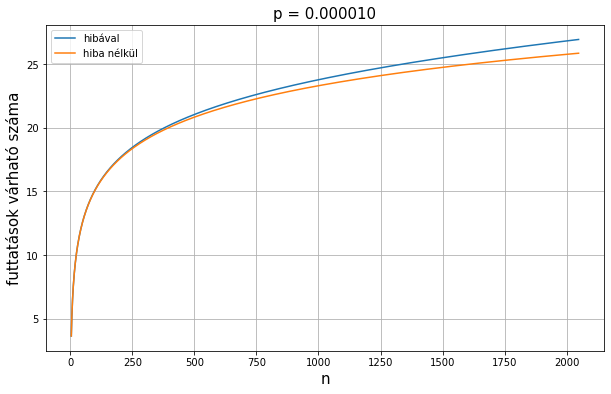

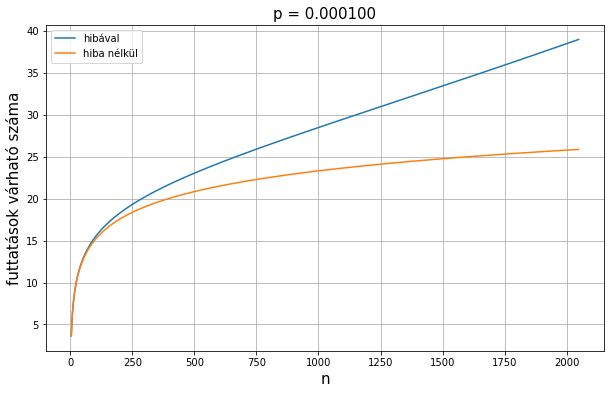

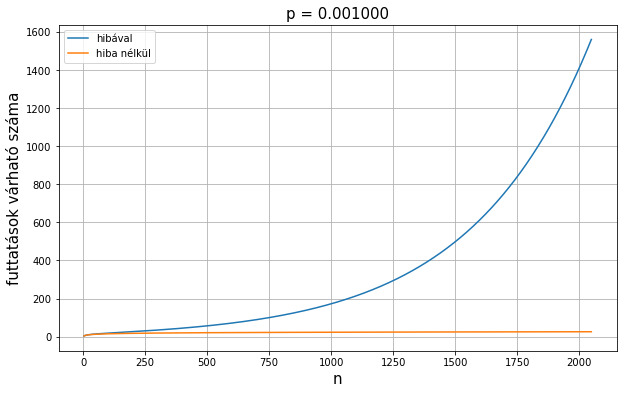

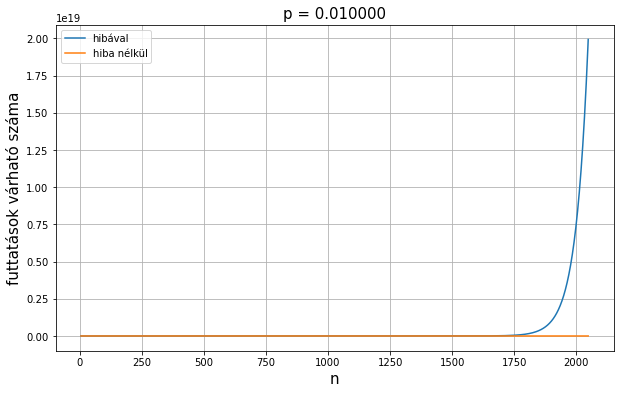

In [8]:
for p in np.logspace(-6, -2, num = 5):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid()
    ax.set_title("p = %f" % p, fontsize=15)
    ax.set_xlabel("n", fontsize=15)
    ax.set_ylabel('futtatások várható száma', fontsize=15)
    n = np.arange(4, 2049)
    ax.plot(n, expect(n, p), '-', label='hibával')
    ax.plot(n, expect(n), '-', label='hiba nélkül')
    ax.legend()

14919.882396822404
21574.994864922493
864165.9953672348
1.1039272714277227e+22


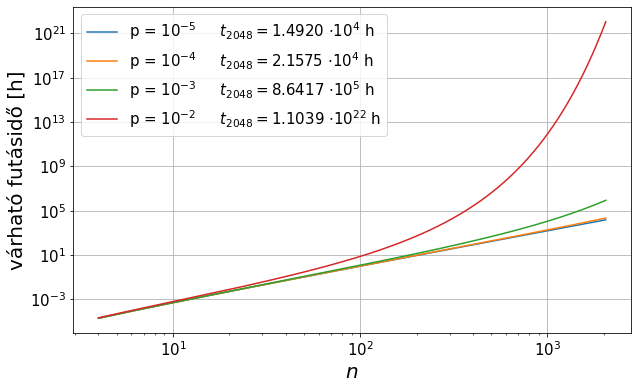

In [43]:
n = np.arange(4, 2049, dtype='float64')
fig, ax = plt.subplots(figsize=(10, 6))
for p in np.logspace(-5, -2, num = 4):
    power = int(np.log10(p))
    t = 10**-6*dep(2048)*expect(2048, p)/3600
    t_e = int(np.log10(t))
    t_b = int(t/10**(t_e-5))/10**5
    format = "{:.4f}".format(t_b)
    s = r'p = $10^{%i}$     $t_{2048}=$'%power + format +r' $\cdot 10^{%i}$ h' %t_e
    ax.plot(n, 10**-6*dep(n)*expect(n, p)/3600, '-', label=s)
    print(10**-6*dep(2048)*expect(2048, p)/3600)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$n$", fontsize=20)
ax.set_ylabel('várható futásidő [h]', fontsize=20)
ax.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.grid()

matplotlib.rcParams.update({'font.size': 15})
plt.savefig('futás_hibával')

### 2048 bites szám faktorizásásához szükséges idő

Text(0.5, 0, '1-p')

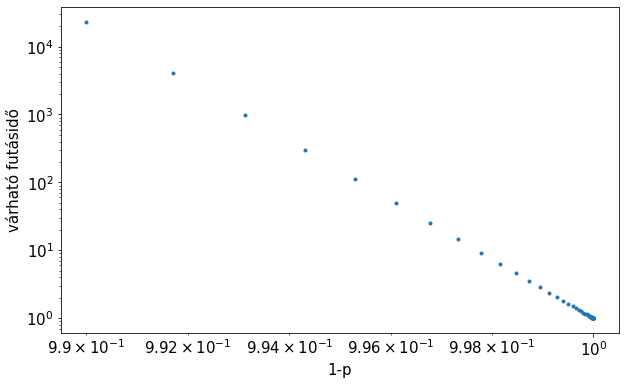

In [17]:
n = 1000
p = np.logspace(-6, -2, num = 50, dtype='float64')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(1-p, 1/(1-p)**n, '.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('várható futásidő', fontsize = 15)
ax.set_xlabel('1-p', fontsize = 15)

## Gate errors

In [13]:
def error(depth, c):
    return 1/2 - np.exp(-c*depth)/2

def error2(n, c):
    return 1-np.exp(-c*(cx(n)+sing(n)))

3.6426330000000004e-08
3.642633e-07
3.6426330000000003e-06
3.642633e-05
0.0003642633


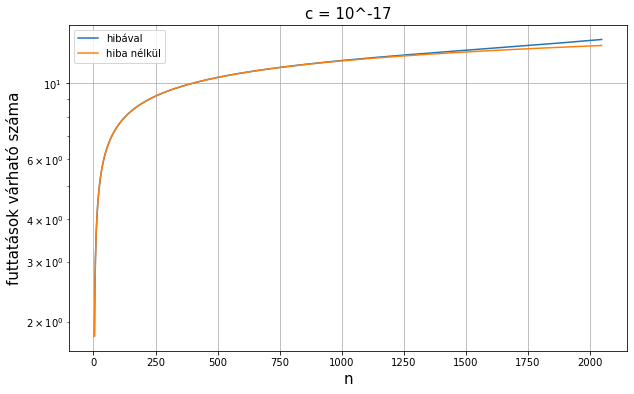

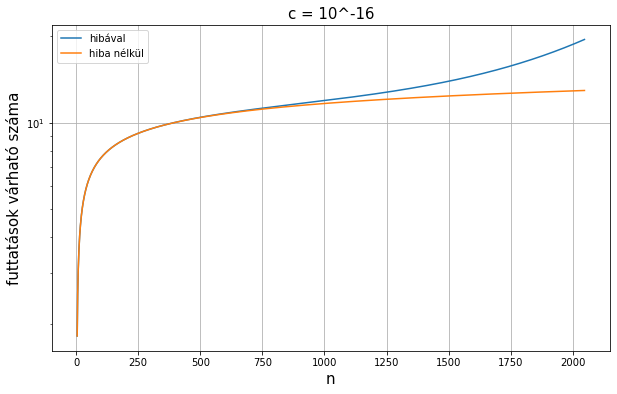

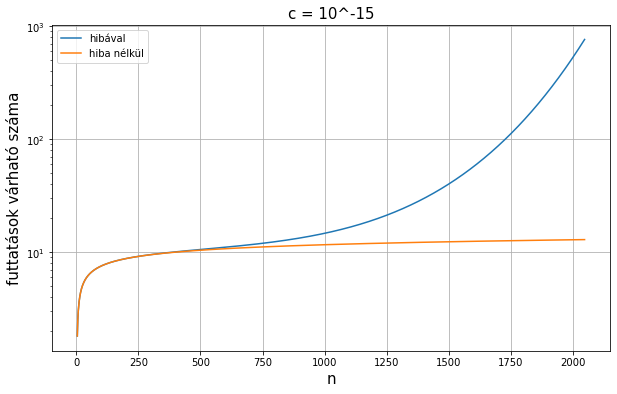

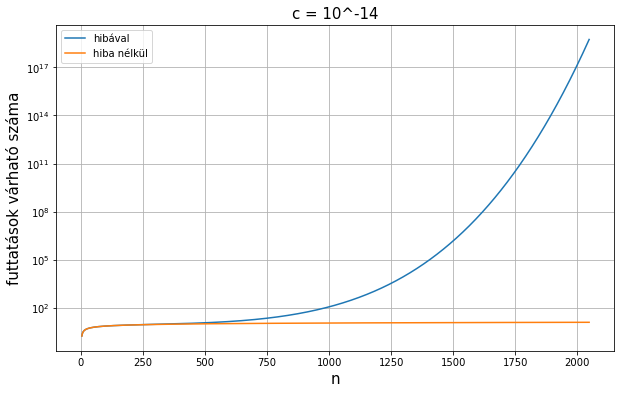

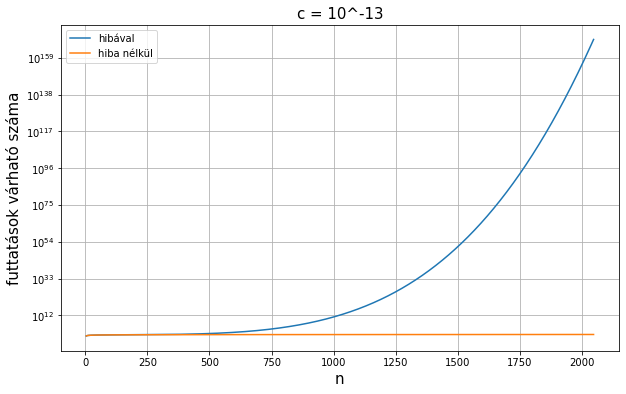

In [94]:
for c in np.logspace(-17, -13, num = 5):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid()
    ax.set_title("c = 10^%i" % int(np.log10(c)), fontsize=15)
    ax.set_xlabel("n", fontsize=15)
    ax.set_ylabel('futtatások várható száma', fontsize=15)
    ax.set_yscale('log')
    n = np.arange(4, 2048, dtype='int64')
    ax.plot(n, expect(n, error(dep(n), c)), '-', label='hibával')
    ax.plot(n, expect(n), '-', label='hiba nélkül')
    ax.legend()

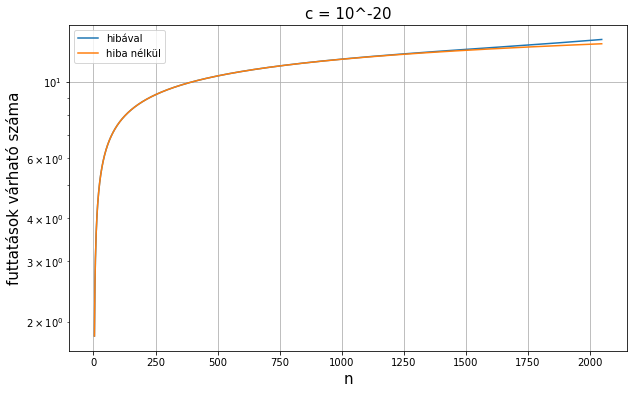

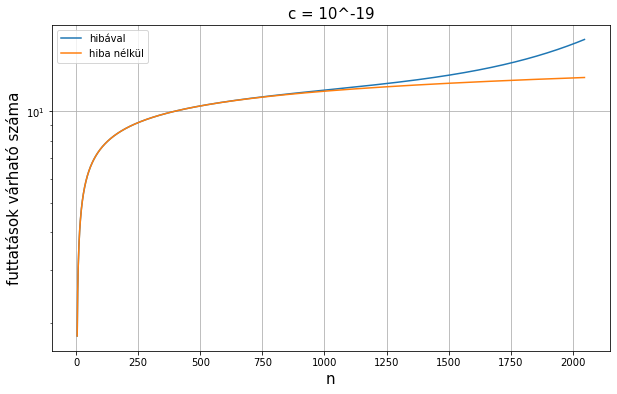

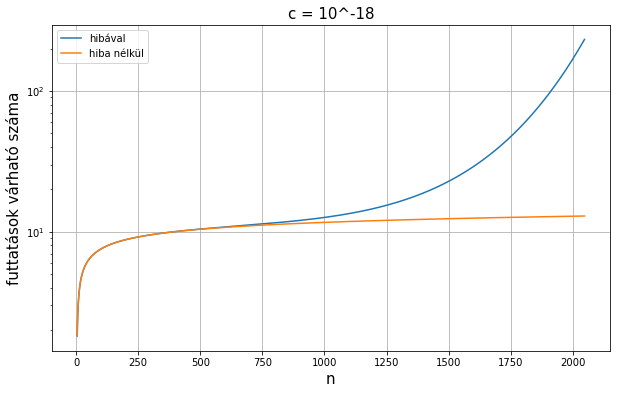

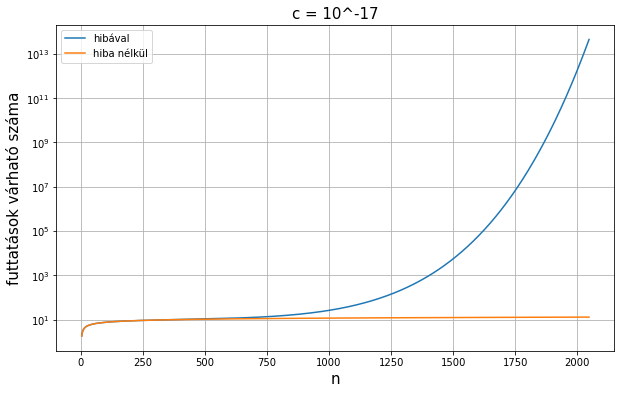

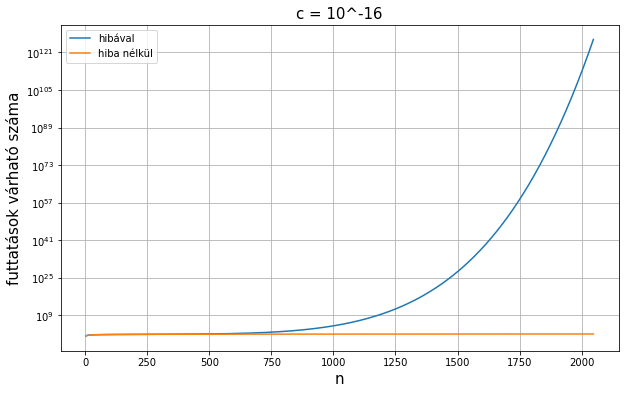

In [102]:
for c in np.logspace(-20, -16, num = 5):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid()
    ax.set_title("c = 10^%i" % int(np.log10(c)), fontsize=15)
    ax.set_xlabel("n", fontsize=15)
    ax.set_ylabel('futtatások várható száma', fontsize=15)
    ax.set_yscale('log')
    n = np.arange(4, 2048, dtype='int64')
    ax.plot(n, expect(n, error2(n, c)), '-', label='hibával')
    ax.plot(n, expect(n), '-', label='hiba nélkül')
    ax.legend()